In [32]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [107]:
base_dir = "/storage/vbsjjlnu/VBSjjlnu_v7"

datasets  = ["output_2016","output_2017","output_2018"]

cut     = "res_sig"
if "res" in cut: 
    phasespace="resolved" 
else:
    phasespace='boosted'
version = "v1"

output_dir = os.path.join(base_dir, "FullRun2_v7", cut, "samples/" + version)

samples_dirs = [os.path.join(base_dir, p) for p in datasets]

lumi = { 2016: 35.867, 2017: 41.5 , 2018: 59.74}

In [108]:
output_dir

'/storage/vbsjjlnu/VBSjjlnu_v7/FullRun2_v7/res_sig/samples/v1'

In [109]:
samples_dirs

['/storage/vbsjjlnu/VBSjjlnu_v7/output_2016',
 '/storage/vbsjjlnu/VBSjjlnu_v7/output_2017',
 '/storage/vbsjjlnu/VBSjjlnu_v7/output_2018']

In [110]:
signal = "VBS"
sample_names = ["Wjets_HT", "VBS", "DY", "top", "VV", "VBF-V", "VVV","Vg", "VgS", "Fake"]

samples = {}

for samples_dir in samples_dirs:
    for sample in sample_names:
        print(samples_dir, sample)
        f1 = f"{samples_dir}/dataframe_{sample}_{cut}_ele_dnn_inputs_{phasespace}.csv"
        f2 = f"{samples_dir}/dataframe_{sample}_{cut}_mu_dnn_inputs_{phasespace}.csv"
        if not os.path.exists(f1):
            break
        eledf = pd.read_csv(f1,sep=',')
        mudf = pd.read_csv(f2,sep=',')
        eledf['lep_flavour'] = 1
        mudf['lep_flavour'] = -1
        
        s =  pd.concat([eledf,mudf], ignore_index=True)
        s["sample_name"] = sample
        if "2016" in samples_dir:
            s["year"] = 2016
            s["weight"] = s["weight"] * lumi[2016]
        if "2017" in samples_dir:
            s["year"] = 2017
            s["weight"] = s["weight"] * lumi[2017]
        if "2018" in samples_dir:
            s["year"] = 2018
            s["weight"] = s["weight"] * lumi[2018]
            
        foundnan = s.isnull().values.any()
        print("Found nan:",foundnan)
        if foundnan:
            null_columns = s.columns[s.isnull().any()]
            print(s[s.isnull().any(axis=1)][null_columns])
            #filling missing values
            s.fillna(value={"vbs_0_qgl_res":-1,"vbs_1_qgl_res":-1,"vbs_0_qgl_boost":-1,"vbs_1_qgl_boost":-1},inplace=True)
            print(s[s.isnull().any(axis=1)][null_columns])
    
        # remove weight 0 events                    
        if sample in samples:
            samples[sample] = pd.concat([samples[sample], s[s.weight!=0.0]], ignore_index=True)
        else:
            samples[sample] = s[s.weight!=0.0]

/storage/vbsjjlnu/VBSjjlnu_v7/output_2016 Wjets_HT
Found nan: True
        vbs_0_qgl_res  vbs_1_qgl_res
69886             NaN       0.010124
70399             NaN       0.098633
73978             NaN       0.811523
75337             NaN       0.999023
76582             NaN       0.015526
...               ...            ...
206007            NaN       0.070984
206019            NaN       0.017227
206031            NaN       0.260986
206038            NaN       0.986328
206049            NaN       0.666016

[167 rows x 2 columns]
Empty DataFrame
Columns: [vbs_0_qgl_res, vbs_1_qgl_res]
Index: []
/storage/vbsjjlnu/VBSjjlnu_v7/output_2016 VBS
Found nan: True
       vbs_0_qgl_res  vbs_1_qgl_res
5573             NaN       0.819824
6564             NaN       0.877441
9827        0.865723            NaN
10276            NaN       0.557617
14033            NaN       0.584961
21415            NaN       0.013977
27378            NaN       0.907227
Empty DataFrame
Columns: [vbs_0_qgl_res, vbs_1_qg

In [111]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight).sum():15}")

Sample name Wjets_HT  , nsamples:     715599,   XS total: 8231875.789788229
Sample name VBS       , nsamples:     218209,   XS total: 67753.57607277209
Sample name DY        , nsamples:     269610,   XS total: 1103628.2637665558
Sample name top       , nsamples:     256199,   XS total: 1425014.9485709479
Sample name VV        , nsamples:     438852,   XS total: 455247.0686961611
Sample name VBF-V     , nsamples:       8210,   XS total: 161726.88649842035
Sample name VVV       , nsamples:       2612,   XS total: 3159.954503839522
Sample name Vg        , nsamples:       3956,   XS total: 91056.93249712337
Sample name VgS       , nsamples:       3657,   XS total: 4990.445651222473
Sample name Fake      , nsamples:     279559,   XS total: 2338732.8665360333


## Balancing

In [112]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets_HT"],
                samples["VV"],
                samples["VBF-V"], 
                samples["VVV"],
                samples["Vg"], 
                samples["VgS"], 
                samples["Fake"], 
                ], ignore_index=True)

signal = samples["VBS"]

In [113]:
'''
If random sampling will be done for the signal we need to assume that the number of signal 
events will be the same of the number of background events --> This assumption will go in the background weight. 
'''
random_sampling = False

### Normalization by bkg events

In [10]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

tot_ev_weighted_bkg = (background.weight_ / background.weight_.mean()).sum()
print("TOT bkg weighted events", tot_ev_weighted_bkg)

rescale_factor_sig  = (tot_ev_weighted_bkg )/ signal.weight_.sum()
print("Rescale facor for signal", rescale_factor_sig)

signal["weight_norm"] = signal.weight_ * rescale_factor_sig
background["weight_norm"] = background.weight_ / background.weight_.mean()

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

7.939936977668173
TOT bkg weighted events 289768.00000000006
Rescale facor for signal 70580.065328993
Effective sig events:  289768.0000000001
Effective bkg events:  289768.00000000006


In [20]:
background.weight_.sum()

1776.771994303065

In [21]:
signal.weight_.sum()

12.259606081710476

### Normalization by signal events

In [114]:
tot_ev_weighted_sig = (signal.weight / signal.weight.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

if random_sampling:
    rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight.sum()
else:
    rescale_factor_bkg = (tot_ev_weighted_sig )/ background.weight.sum()
print(rescale_factor_bkg)

signal["weight_norm"] = signal.weight / signal.weight.mean()
background["weight_norm"] = background.weight * rescale_factor_bkg

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

TOT signal weighted events 218208.99999999994
0.0157945825894862
Effective sig events:  218208.99999999994
Effective bkg events:  218209.0


## Save signal and bkg samples

In [115]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

In [15]:
signal.columns

Index([                      0,                  'A_ww',
                    'Asym_vbs',             'Centr_vbs',
                    'Centr_ww',              'Lep_proj',
                   'Lep_projw',            'Lepton_eta',
                  'Lepton_phi',             'Lepton_pt',
                     'Mtw_lep',                'Mw_lep',
                         'Mww',          'PuppiMET_phi',
                 'PuppiMET_pt',                  'R_mw',
                        'R_ww',              'Rvjets_0',
                        'Zlep',              'Zvjets_0',
               'deltaR_lep_nu',        'deltaR_lep_vbs',
             'deltaR_lep_vjet',            'deltaR_vbs',
                 'deltaR_vjet',       'deltaeta_lep_nu',
                'deltaeta_vbs',       'deltaphi_lep_nu',
                'deltaphi_vbs',         'fatjet_TvsQCD',
               'fatjet_WvsQCD',         'fatjet_ZvsQCD',
           'fatjet_subjet1_pt',     'fatjet_subjet2_pt',
       'fatjet_subjet_ptratio',

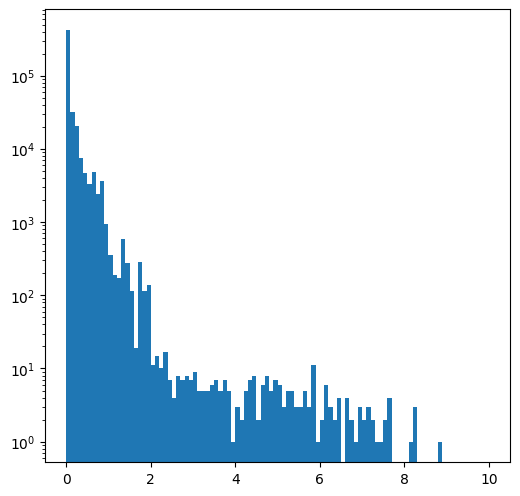

In [28]:
plt.hist(background["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

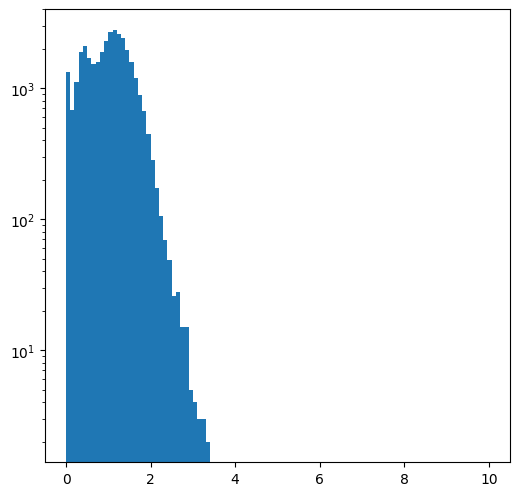

In [29]:
plt.hist(signal["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

The total number of events will be manually balanced

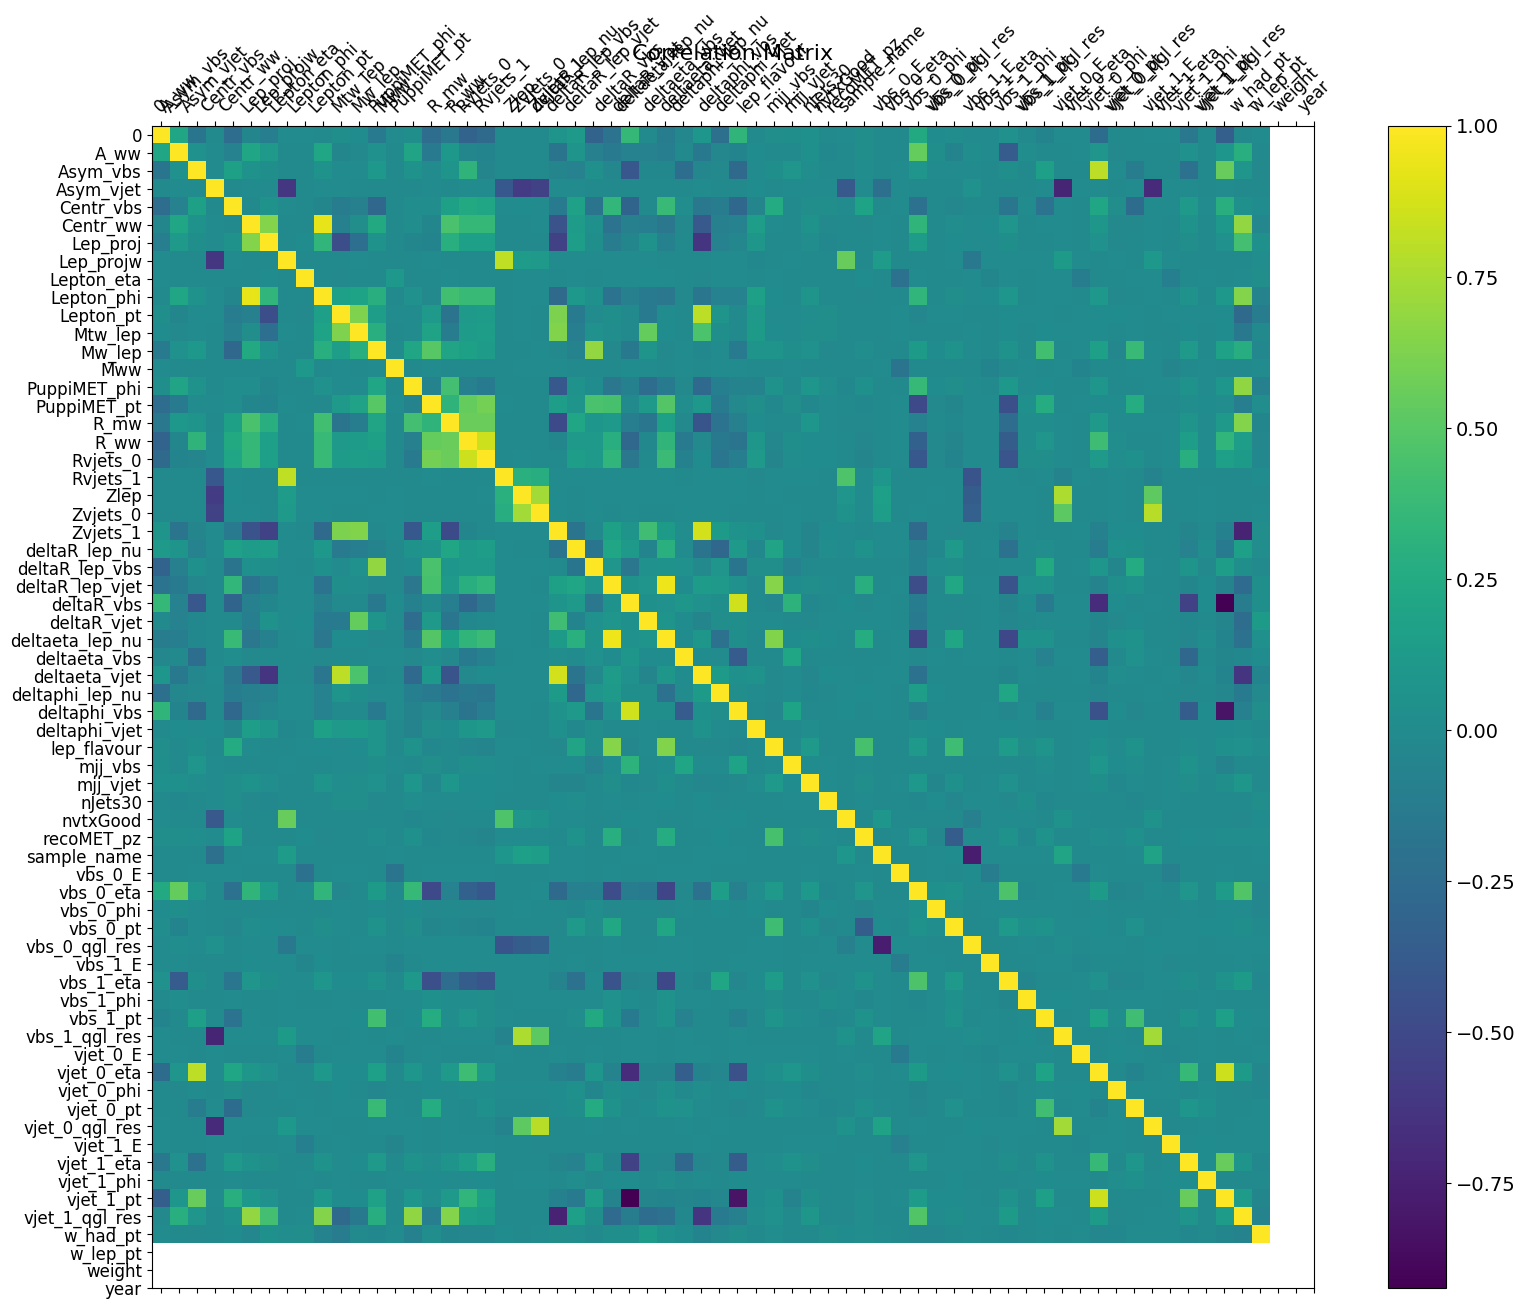

In [30]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);